In [2]:
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(effects))
suppressPackageStartupMessages(library(nlme))

# Generalised Least Squares
We will start our journey into the world of mixed-effects models by first examining a *related* approach that we have seen before: Generalised Least Squares (GLS). The reason for doing this is twofold. Firstly, GLS actually provides a simpler solution to many of the issues with the repeated measures ANOVA and thus presents a more logical starting point. Secondly, limitations in the way that GLS does this will provide some motivation for mixed-effects as a more complex, but ultimately more flexible, method of dealing with this problem.

## GLS Theory
We previously came across GLS in the context of allowing different variances for different groups of data in ANOVA-type models. This was motivated as a way of lifting the assumption of *homogeneity of variance*. However, GLS is actually a much more general technique. To see this, note that the probability model for GLS is

$$
\mathbf{y} \sim \mathcal{N}\left(\boldsymbol{\mu},\boldsymbol{\Sigma}\right),
$$

where $\boldsymbol{\Sigma}$ can take on *any structure*. In other words, GLS has exactly the same probability model as the normal linear model, except that it allows for a flexible specification of the variance-covariance matrix. In our previous examples, we used GLS to populate the variance-covariance matrix with different variances for each group. For instance, if we had two groups with three subjects each, our GLS model would be

$$
\begin{bmatrix}
y_{11} \\
y_{21} \\
y_{31} \\
y_{12} \\
y_{22} \\
y_{32} \\
\end{bmatrix}
\sim\mathcal{N}\left(
\begin{bmatrix}
\mu_{1} \\
\mu_{1} \\
\mu_{1} \\
\mu_{2} \\
\mu_{2} \\
\mu_{2} \\
\end{bmatrix},
\begin{bmatrix}
\sigma^{2}_{1}  & 0              & 0              & 0              & 0              & 0              \\
0               & \sigma^{2}_{1} & 0              & 0              & 0              & 0              \\
0               & 0              & \sigma^{2}_{1} & 0              & 0              & 0              \\
0               & 0              & 0              & \sigma^{2}_{2} & 0              & 0              \\
0               & 0              & 0              & 0              & \sigma^{2}_{2} & 0              \\
0               & 0              & 0              & 0              & 0              & \sigma^{2}_{2} \\
\end{bmatrix}
\right).
$$

This was actually a special case of GLS known as *weighted least squares* (WLS)[^weights-foot], where all the off-diagonal elements of $\boldsymbol{\Sigma}$ are 0. However, the crucial point is that  we can use GLS to impose differences in *both* the variances *and* the covariances. So while we did not do this previously, we can include *correlation* in the GLS model. Thus, if our general problem with repeated measures is that the variance-covariance structure is not correctly handled by the normal linear model, GLS provides a direct solution. Furthermore, if a core complaint of the repeated measures ANOVA is that the assumed covariance structure is too restrictive, GLS again provides a direct solution. So, on the face of it, GLS directly solves many of the issues we encountered last week.

### What Does GLS Do?
Technically, the machinery behind GLS is based on assuming we know $\boldsymbol{\Sigma}$ *a priori*. Although this would seem a silly place to start (given that we will almost *never* know this), we can go along with it and see where it gets us. So, *if* we know what the true covariance structure is, GLS provides a way of *removing* it from the data[^white-foot]. Once removed, the errors return to $i.i.d.$ and we are back in the world of the normal linear model. This is a very enticing prospect because all the difficulties associated with correlation effectively *disappear* and we can treat the data as a regular collection of independent values. So, although this *removal* procedure happens behind the scenes, we can conceptualise GLS as effectively a *transformation* that treats the covariance structure as *nuisance* and removes it, allowing all the theory from last semester to still apply.

Unfortunately, this only really works is we *know* $\boldsymbol{\Sigma}$. In the real world, where we never know $\boldsymbol{\Sigma}$, we cannot technically use GLS. This would seem a bit of a dead-end. However, it is possible to use a method such as REML to *estimate* $\boldsymbol{\Sigma}$ from the data. This is known as *feasible generalised least squares* (FGLS). The question then becomes, how does working with $\hat{\boldsymbol{\Sigma}}$ rather than $\boldsymbol{\Sigma}$ change things? This is actually a much bigger question that extends to *any* method where we allow for a completely arbitrary covariance structure, rather than restricting it to a very specific form. Although our complaint about repeated measures ANOVA was that the covariance assumptions were unrealistic, as it turns out, these assumptions are *essential* to prevent the exact inferential machinery used within the linear model from breaking. Our desire for generality comes at a cost, as we will now discuss.

## Covariance Constraints
As well as understanding that the very process of estimating $\boldsymbol{\Sigma}$ causes problems, we also need to understand that we cannot have free reign to estimate any old covariance structure we like. One of the most important elements to recognise is that some sort of *constraint* is always needed when estimating a variance-covariance matrix. To see this, note that for a repeated measures experiment there are $nt \times nt$ values in this matrix. The values above and below the diagonal are a mirror image, so the true number of unknown values is $\frac{nt(nt + 1)}{2}$. For instance, if we had $n = 5$ subjects and $t = 3$ repeated measures, there would be $\frac{15 \times 16}{2} = 120$ unique values in the variance-covariance matrix. If we allowed it to be completely unstructured, we would have 120 values to estimate *just* for the covariance structure. Indeed, this is not really possible unless the amount of data we have *exceeds* the number of parameters. So, the data itself imposes a *constraint* on how unstructured the covariance matrix can be.

Luckily, for most applications, we not only assume that $\boldsymbol{\Sigma}$ has a block-diagonal structure (so most off-diagonal entries are 0), but that many of the off-diagonal elements are actually *identical*. We saw this previously with the repeated measures ANOVA. Even though $\boldsymbol{\Sigma}$ may have *hundreds* of values we *could* fill-in, if we assume compound symmetry only within each subject, there are only *two* covariance parameters to be estimated: $\sigma^{2}_{b}$ and $\sigma^{2}_{w}$. The whole matrix can then be constructed using those two alone. This is an example of *extreme simplification*, but it does highlight that we generally do not estimate the *whole* variance-covariance matrix. We only estimate *small parts* of it. Indeed, making the covariance matrix more general is often a risky move because of the number of additional parameters needed. The more we estimate from the same data, the greater our uncertainty will become because each element of the covariance-matrix is supported by *less data*. Complexity always comes at a price.

## GLS in `R`
We have seen some examples of using the `gls()` function from `nlme` last semester. At that point, we only focused on the use of the `weights=` argument with different variance structures (e.g. `varIdent()`, `varPower()` etc.). However, there is also a `correlation=` argument that similarly takes a number of pre-specified correlation structures. We can use these two arguments together to form a final variance-covariance matrix that consists of correlation and heterogenous variance groups. 

### The Paired $t$-test Using GLS
We can start with the most simple example of the paired $t$-test using GLS. Importantly, this is an unnecessary step theoretically because the paired $t$-test is a perfectly acceptable technique. When there are only two-repeats there are no arguments about the covariance structure. There can only be a single correlation term. So compound symmetry always works. However, it is useful for us as a *starting point* because it is the simplest example of the problem.

In order to specify a correlation structure, we need to pass one of the predefined correlation functions as an argument to `correlation=`. These structures include functions such as `corCompSymm()`, `corSpher()`, `corAR1()` and `corSymm()`[^corfunc-foot]. For this example, we will use `corCompSymm()`, which constructs a compound symmetric structure.

In order to use `corCompSymm()`, we need to supply it with a description of how we want it structured in relation to our data. This is done using the `form=` argument, which takes a one-sided formula expressing the structure we want. For this example, we will use `corCompSymm(form= ~1|subject)`. This indicates that we want a constant correlation (`1`) grouped by subject (`|subject`). So, the term on the *right* of `|` is key here. This gives a *grouping factor* such that any observations from the same level will share a constant correlation. Because we have used `subject`, each level represents a *different* subject and thus any observations that come from the same subject will be correlated. This therefore defines our *block-diagonal* covariance structure, where the term on the right of `|` forms the *blocks*. We will see ways to visualise this in order to provide more intuition a little later.

Returning to our example, we will use the `mice2` data from `datarium` again, which we have converted to long-format as discussed last week.

In [3]:
library('datarium')
library('reshape2')
data('mice2')

# repeats and number of subjects
t <- 2
n <- dim(mice2)[1]

# reshape wide -> long
mice2.long <- melt(mice2,                       # wide data frame
                   id.vars='id',                # what stays fixed?
                   variable.name="time",        # name for the new predictor
                   value.name="weight")         # name for the new outcome

mice2.long <- mice2.long[order(mice2.long$id),] # order by ID
rownames(mice2.long) <- seq(1,n*t)              # fix row names
mice2.long$id <- as.factor(mice2.long$id)

print(mice2.long)

   id   time weight
1   1 before  187.2
2   1  after  429.5
3   2 before  194.2
4   2  after  404.4
5   3 before  231.7
6   3  after  405.6
7   4 before  200.5
8   4  after  397.2
9   5 before  201.7
10  5  after  377.9
11  6 before  235.0
12  6  after  445.8
13  7 before  208.7
14  7  after  408.4
15  8 before  172.4
16  8  after  337.0
17  9 before  184.6
18  9  after  414.3
19 10 before  189.6
20 10  after  380.3


To fit this model using GLS, we use

In [4]:
library(nlme)

gls.mod <- gls(weight ~ time, correlation=corCompSymm(form=~1|id), data=mice2.long)

where we can see the use of the `correlation=` argument with the `corCompSymm()` function. We could also optionally include a `weights=` argument if we wanted the diagonal elements of the covariance matrix to differ by `time`. This would take the form `weights=varIdent(form= ~1|time)`. However, we will keep this simple for now.

### Inference Using GLS
Although we should check the assumptions of the GLS model, we will leave that to one side given that we covered it last semester. The more pressing issue for us is to discuss *inference* using the GLS model, especially given the problems highlighted earlier. To begin with, we can treat the returned objects from `gls()` just like an object from `lm()` and call `summary()` to examine the model estimates and tests.

In [5]:
print(summary(gls.mod))

Generalized least squares fit by REML
  Model: weight ~ time 
  Data: mice2.long 
      AIC      BIC    logLik
  177.349 180.9105 -84.67449

Correlation Structure: Compound symmetry
 Formula: ~1 | id 
 Parameter estimate(s):
      Rho 
0.5332493 

Coefficients:
             Value Std.Error  t-value p-value
(Intercept) 200.56  8.081914 24.81591       0
timeafter   199.48  7.808574 25.54628       0

 Correlation: 
          (Intr)
timeafter -0.483

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.46661859 -0.54818094  0.02112903  0.38482224  1.79048964 

Residual standard error: 25.55725 
Degrees of freedom: 20 total; 18 residual


We can see here all the usual output that matches what `lm()` gives us. Indeed, despite what we mentioned earlier, we still get $t$-statistics and $p$-values (though note that the $p$-values are *rounded* rather than displayed using scientific notation). We also have information on the estimated correlation structure, with the single correlation parameter given by $\hat{\rho} = 0.53$. Of most importance is that both the *standard error* and *$t$-value* match what we saw last week from the paired $t$-test. This is evidence enough to show that the correlation *is* being taken into account. Importantly, this is being done within a linear model framework, but *without* the need to subtract the differences *or* to manually partition the errors by including `id` in the model formula.

#### The $p$-value Problem
Although all the elements highlighted above are positives, there is something important we need to recognise about the reported $p$-values. As mentioned earlier, if we work with the idea that $\boldsymbol{\Sigma}$ is *estimated* then the null distribution of the test statistics become unknown and there is no way to calculate a $p$-value. And yet, the `gls()` function *does* produce $p$-values. How? *Because it is acting as if $\boldsymbol{\Sigma}$ is known*. In effect, even though we are using FGLS, the `gls()` function ignores this and acts as if we are doing *proper* GLS with a known covariance structure. All the calculations of $t$-statistics, degrees of freedom and $p$-values are based on assuming that $\boldsymbol{\Sigma}$ is known and thus we can perfectly remove the covariance structure from the data and end-up back in the world of a normal linear model.

The problem with this is that the uncertainty in estimating $\boldsymbol{\Sigma}$ is not taken into account. Indeed, we have seen that there is no exact way of quantifying this uncertainty because the concept of degrees of freedom vanishes as soon as the sampling distribution becomes unknown. The `gls()` function is *pretending* that we known $\boldsymbol{\Sigma}$ and can return the model to a world where degrees of freedom exist and null distributions are known. The extent to which we can trust the $p$-values therefore depends upon the extent to which we are willing to follow along with this fiction. At best, we need to treat these values as *very rough approximations* and nothing more. This is especially true in *small samples*. As mentioned earlier, as $n$ gets larger the estimate of $\hat{\boldsymbol{\Sigma}}$ gets closer to the true value and the uncertainty largely disappears. So if our sample is *large*, we have less concern with the GLS tests. However, great caution is needed if our sample is *small*.

Part of the problem here is that FGLS knows *nothing* about the structure of the data. The very fact that we have repeated measurements from multiple subjects is somewhat lost inside of $\boldsymbol{\Sigma}$. All GLS knows is that there *is* correlation, but not *where it came from*. As we will see, mixed-effects models actively embed the structure that causes the data to be correlated. This does not magically get rid of the problem of an unknown sampling distribution under an arbitrary covariance structure, but it does allow for a better approximation of the uncertainty that comes from estimating $\boldsymbol{\Sigma}$. So, a mixed-effects model will not fix this situation, but it does give us better options beyond simply pretending that $\boldsymbol{\Sigma}$ is known. This is not the main reason for using mixed-effects over GLS, but it is an advantage.

#### Omnibus Tests and Follow-ups
Putting aside the inferential issues above, the utility of the GLS framework is that we can simply treat the model in the same way as a result from `lm()`. This means we can compute ANOVA-style tests 

In [6]:
anova(gls.mod)

Denom. DF: 18 
            numDF   F-value p-value
(Intercept)     1 1800.9410  <.0001
time            1  652.6124  <.0001

generate confidence intervals (though these should similarly be treated cautiously),

In [7]:
confint(gls.mod)

               2.5 %   97.5 %
(Intercept) 184.7197 216.4003
timeafter   184.1755 214.7845

create plots using the `effects` package

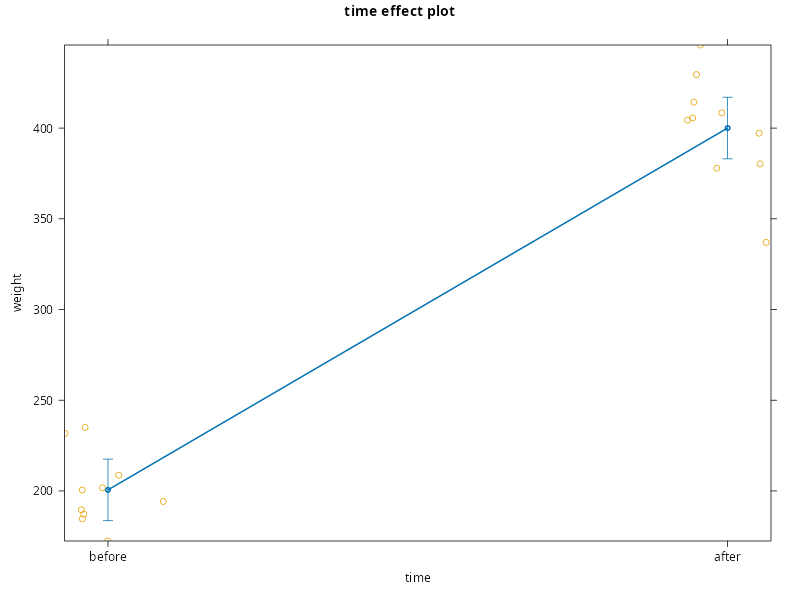

In [8]:
library('effects')
plot(effect('time', gls.mod, residuals=TRUE), partial.residuals=list(smooth=FALSE))

and compute follow-up tests using `emmeans`[^emmeans-foot]

In [9]:
library(emmeans)
emm <- emmeans(gls.mod, pairwise ~ time, mode="df.error")
print(emm$contrasts)

 contrast       estimate   SE df t.ratio p.value
 before - after     -199 7.81 17 -25.546  <.0001

Degrees-of-freedom method: df.error 


So, if we put the inferential issues to one side, we can see that GLS provides a nice alternative to the repeated measures ANOVA because it exists within the linear model framework and thus allows us to use all the methods we have seen previously. Furthermore, we can lift the assumption of compound symmetry and use a variety of different covariance matrices. The main downside is that this comes with a price in terms of the $p$-value not taking the uncertainty in the estimation of the covariance structure into account. This is especially problematic in *small samples*, which means we should really treat the hypothesis tests from a GLS model as only *asymptotically correct*. If we are happy to do so, GLS becomes quite a useful method to have on hand. We will see a few more examples of using GLS with more complex ANOVA models in the associated workshop.

[1] 0


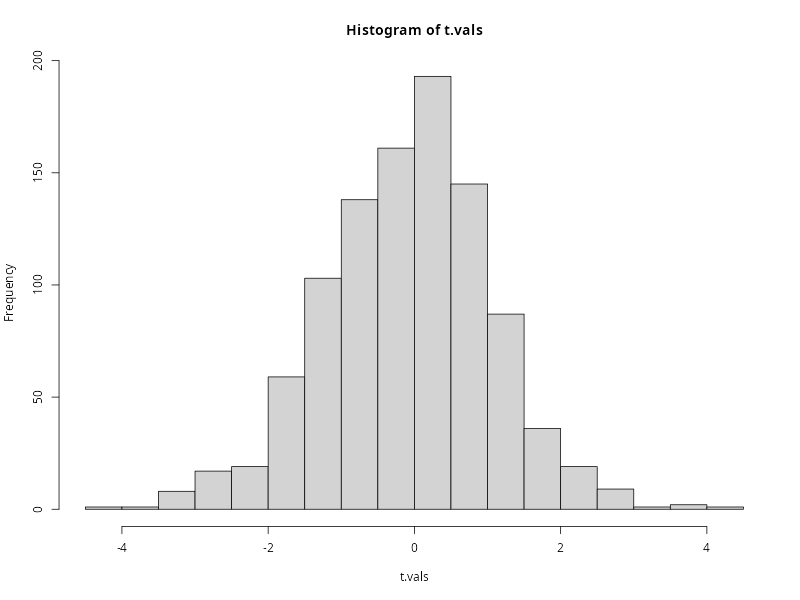

In [32]:
library(Matrix)

gls_marginal_cov <- function(fit) {
  n <- nobs(fit)

  # Correlation blocks (list) or single matrix if no grouping
  cs <- fit$modelStruct$corStruct
  if (is.null(cs)) {
    # No correlation structure: R = I
    Rlist <- list(Matrix::Diagonal(n))
    g <- factor(rep("all", n))
  } else {
    Rlist <- corMatrix(cs)
    g <- getGroups(fit)
    if (is.null(g)) g <- factor(rep("all", n))
  }

  # Variance weights (if no varStruct, all 1s)
  vs <- fit$modelStruct$varStruct
  w <- if (is.null(vs)) rep(1, n) else varWeights(vs)

  # Indices per group, aligned to the same order as used in the fit
  idx <- split(seq_along(g), g)

  sig2 <- fit$sigma^2

  # Build block covariance matrices: Sigma_g = sig2 * D^(1/2) R D^(1/2)
  # In nlme, varWeights are (typically) inverse-SD-type weights, so Var(e_i) = sig2 / w_i^2.
  Sig_blocks <- Map(function(R, ii) {
    Dhalf <- Matrix::Diagonal(x = 1 / w[ii])
    sig2 * (Dhalf %*% R %*% Dhalf)
  }, Rlist, idx)

  Matrix::bdiag(Sig_blocks)
}

library(nlme)
library(MASS)

full.fit <- gls(weight ~ time, correlation=corCompSymm(form=~1|id), data=mice2.long)
null.fit <- gls(weight ~ 1,    correlation=corCompSymm(form=~1|id), data=mice2.long)

Sigma_hat <- gls_marginal_cov(null.fit)

n.sims <- 1000
t.vals <- numeric(n.sims)

for (i in 1:n.sims) {
  y_star            <- as.vector(mvrnorm(1, mu=fitted(null.fit), Sigma = Sigma_hat))
  mice2.long$y_star <- y_star

  fit_b <- gls(y_star ~ time, correlation=corCompSymm(form=~1|id), data=mice2.long)

  t.vals[i] <- summary(fit_b)$tTable["timeafter", "t-value"]
}

# empirical p-value
hist(t.vals, breaks=20)
t_obs <- summary(full.fit)$tTable["timeafter", "t-value"]
p_boot <- mean(abs(t.vals) >= abs(t_obs))
print(p_boot)


## When Should We Use GLS?
GLS is most useful in situations where we know what covariance structure we want to impose on the data and are not as concerned about the model not understanding any form of deeper structure in the data. However, if we do not know the covariance structure and know that the data has a deeper structure that the model should be able to exploit, this is where mixed-effects models come into their own. 

... The problem is that GLS does not know anything about the *structure* of the data. It has no sense of *subjects* as the experimental unit, nor the idea that the outcome variable is comprised of clusters of values taken from different subjects who might themselves form clusters of values from larger groups (e.g. patients vs controls). All that GLS knows is that there is a correlation structure that we want to remove. Unfortunately, this lack of appreciation for the structure of the data means that GLS cannot use that structure to its advantage. There is no separation of the information available by pooling observations across subjects, or subjects across groups. In effect, GLS is a very *crude* solution to a bigger problem with repeated measurements. Namely, that there is a larger *hierarchical* structure at play that the model should be able to take advantage of. We have seen this in a very general way through small-sample degrees of freedom, but really this is only a *symptom* of a larger problem. As we will come to learn, mixed-effects models are advantageous precisely *because* they embed this structure in the model. This has a number of consequences, not least the fact that correlation between measurements from the same experimental unit are *automatically* embedded in the model. This is not because we tell the model to include correlation, rather it is a *natural consequence* of the structure of the data. As such, mixed-effects models are useful because features such as correlation are a natural part of the modelling framework, precisely because it does take the structure into account in a way that GLS simply cannot.

[^weights-foot]: This is why the argument in `gls()` was `weights=`.

[^corfunc-foot]: You can look up descriptions of all of these using `?corClasses` at the prompt. 

[^white-foot]: This is sometimes known as *whitening* the data. This is a term you may come across in the neuroimaging literature, particularly in relation to how fMRI is analysed.

[^emmeans-foot]: The `mode=` option has been set to `df.error` so that the reported test matches the table from `summary()`. `emmeans` actually has some better ways of adjusting the degrees of freedom to accommodate the uncertainty in estimating $\boldsymbol{\Sigma}$, but this is a complication we will leave to one side for now.